In [79]:
import torch
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer.autoguide import AutoMultivariateNormal, AutoNormal

from src.model import generate_data_purchase, logistic_regression_model_purchase

## Test Combination of SVI and MAP

In [2]:
# import pyro
# import pyro.distributions as dist
# import torch
# from pyro.infer import SVI, Trace_ELBO
# from pyro.optim import Adam

# # Model with theta (random) and phi (deterministic)
# def model(data):
#     # theta: stochastic, inferred using SVI
#     theta = pyro.sample("theta", dist.Normal(0, 1))
    
#     # phi: deterministic, inferred using MAP
#     phi = pyro.param("phi", torch.tensor(1.0))  # MAP parameter
    
#     with pyro.plate("data", len(data)):
#         pyro.sample("obs", dist.Normal(theta + phi, 1), obs=data)

# # Guide with variational distribution for theta, MAP for phi
# def guide(data):
#     # Variational distribution for theta (SVI)
#     theta_loc = pyro.param("theta_loc", torch.tensor(0.0))
#     theta_scale = pyro.param("theta_scale", torch.tensor(1.0), constraint=dist.constraints.positive)
#     pyro.sample("theta", dist.Normal(theta_loc, theta_scale))
    
#     # No variational distribution for phi; it's a MAP parameter

# # Generate some fake data
# data = torch.randn(100)

# # Set up the optimizer
# optimizer = Adam({"lr": 0.01})

# # Set up the SVI object
# svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# # Training loop
# num_iterations = 1000
# for step in range(num_iterations):
#     loss = svi.step(data)
#     if step % 100 == 0:
#         print(f"Step {step} : Loss = {loss}")

# # Get the final MAP value for phi
# phi_map = pyro.param("phi").item()
# print(f"MAP estimate for phi: {phi_map}")

# # Get the variational parameters for theta
# theta_loc = pyro.param("theta_loc").item()
# theta_scale = pyro.param("theta_scale").item()
# print(f"Variational estimate for theta: mean = {theta_loc}, scale = {theta_scale}")


## Test Purchase Model

In [115]:
import pyro
import pyro.distributions as dist
import torch
import numpy as np
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer.autoguide import AutoNormal, AutoMultivariateNormal

def model(x, y):
    # MAP parameters
    beta_price = pyro.param('beta_price', torch.tensor(0.0))
    beta_gender = pyro.param('beta_gender', torch.tensor(0.0))
    beta_income = pyro.param('beta_income', torch.tensor(0.0))
    beta_exposure = pyro.param('beta_exposure', torch.tensor(0.0))
    # SVI parameters
    beta_intercept = pyro.sample('beta_intercept', dist.Normal(0, 10))
    # beta_nonmiss = pyro.sample('beta_nonmiss', dist.Normal(0, 1))
    beta_nonmiss = pyro.sample('beta_nonmiss', dist.Normal(-np.log(1 / 0.8 - 1), 0.1))
    # Define likelihood
    ## Create a tensor of beta coefficients
    beta = torch.stack([beta_price, beta_gender, beta_income, beta_exposure, beta_intercept])
    ## Augment x with an intercept column
    x_augmented = torch.cat([x, torch.ones(x.shape[0], 1)], dim=1)
    ## Calculate log_odds using matrix multiplication
    log_odds = torch.matmul(x_augmented, beta)
    ## Apply nonmiss rate adjustment
    probs = torch.sigmoid(beta_nonmiss) * torch.sigmoid(log_odds)
    ## Sample from the likelihood
    with pyro.plate('data', x.shape[0]):
        return pyro.sample('obs', dist.Bernoulli(probs), obs=y)
    
# def guide(data):
#     # Variational distribution for theta (SVI)
#     beta_intercept_loc = pyro.param('beta_intercept_loc', torch.tensor(0.0))
#     beta_intercept_scale = pyro.param('beta_intercept_scale', torch.tensor(0.0))
#     beta_nonmiss = pyro.sample('beta_nonmiss', dist.Normal(0, 1))
#     theta_loc = pyro.param("theta_loc", torch.tensor(0.0))
#     theta_scale = pyro.param("theta_scale", torch.tensor(1.0), constraint=dist.constraints.positive)
#     pyro.sample("theta", dist.Normal(theta_loc, theta_scale))
#     # No variational distribution for phi; it's a MAP parameter

# Using a built-in guide (AutoNormal) for SVI
# guide = AutoNormal(model)
guide = AutoMultivariateNormal(model)

# Generate data
## True parameters
num_points = 10000
beta_price = torch.tensor(-0.01)
beta_gender = torch.tensor(0.1)
beta_income = torch.tensor(0.02)
beta_exposure = torch.tensor(0.3)
beta_intercept = torch.tensor(-1)
beta_nonmiss = torch.tensor(-np.log(1 / 0.8 - 1))
## Features
feat_price = dist.Uniform(20, 100).sample((num_points,))
feat_gender = dist.Bernoulli(0.5).sample((num_points,))
feat_income = dist.Uniform(10, 100).sample((num_points,))
feat_exposure = dist.Bernoulli(0.2).sample((num_points,))
x = torch.stack([feat_price, feat_gender, feat_income, feat_exposure], dim=1)
## Observations
log_odds = torch.matmul(
    torch.cat([x, torch.ones(num_points, 1)], dim=1),
    torch.tensor([beta_price, beta_gender, beta_income, beta_exposure, beta_intercept])
)
y = dist.Bernoulli(torch.sigmoid(beta_nonmiss) * torch.sigmoid(log_odds)).sample()
print(torch.sigmoid(beta_nonmiss), y.mean())

# Run inference
## Clear the param store in case we're rerunning this cell
pyro.clear_param_store()
## Setup the optimizer
optimizer = Adam({"lr": 0.01, "betas": (0.90, 0.999)})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
## Perform inference
num_steps = 5000
for step in range(num_steps):
    loss = svi.step(x, y)
    if step % 500 == 0:
        print(f"Step {step}, Loss: {loss}") # , Loc: {dict(guide.locs.named_parameters())}")

tensor(0.8000, dtype=torch.float64) tensor(0.3278)
Step 0, Loss: 6746.076868534088
Step 500, Loss: 6102.819264650345
Step 1000, Loss: 6100.533207416534
Step 1500, Loss: 6105.740739583969
Step 2000, Loss: 6103.390558004379
Step 2500, Loss: 6103.442489624023
Step 3000, Loss: 6097.894700050354
Step 3500, Loss: 6100.647599220276
Step 4000, Loss: 6101.67961025238
Step 4500, Loss: 6101.471043348312


In [116]:
# Examine the posterior
## Truth
print(f'Truth: \n'
      f' beta_price: {beta_price} \n'
      f' beta_gender: {beta_gender} \n'
      f' beta_income: {beta_income} \n'
      f' beta_exposure: {beta_exposure} \n'
      f' beta_intercept: {beta_intercept} \n'
      f' beta_nonmiss: {beta_nonmiss} \n')
## MAP parameters
beta_price_map = pyro.param('beta_price').item()
beta_gender_map = pyro.param('beta_gender').item()
beta_income_map = pyro.param('beta_income').item()
beta_exposure_map = pyro.param('beta_exposure').item()
print(f'MAP estimates: \n'
      f' beta_price: {beta_price_map} \n'
      f' beta_gender: {beta_gender_map} \n'
      f' beta_income: {beta_income_map} \n'
      f' beta_exposure: {beta_exposure_map} \n')
## SVI parameters
### Using AutoNormal
# beta_intercept_loc_map = pyro.param('AutoNormal.locs.beta_intercept').item()
# beta_intercept_scale_map = pyro.param('AutoNormal.scales.beta_intercept').item()
# beta_nonmiss_loc_map = pyro.param('AutoNormal.locs.beta_nonmiss').item()
# beta_nonmiss_scale_map = pyro.param('AutoNormal.scales.beta_nonmiss').item()
# print(f'SVI estimates: \n'
#       f' beta_intercept: {beta_intercept_loc_map} ± {beta_intercept_scale_map} \n'
#       f' beta_nonmiss: {beta_nonmiss_loc_map} ± {beta_nonmiss_scale_map} \n')
### Using AutoMultivariateNormal
loc = pyro.param('AutoMultivariateNormal.loc').data
cov = pyro.param('AutoMultivariateNormal.scale').data * pyro.param('AutoMultivariateNormal.scale_tril').data
cov = cov @ cov.T
print(f'SVI estimates: \n'
      f' Mean (beta_intercept, beta_nonmiss): {loc} \n'
      f' Covariance (beta_intercept, beta_nonmiss): {cov} \n'
      f' Sqrt(Covariance) (beta_intercept, beta_nonmiss): {torch.sqrt(torch.abs(cov))} \n')



Truth: 
 beta_price: -0.009999999776482582 
 beta_gender: 0.10000000149011612 
 beta_income: 0.019999999552965164 
 beta_exposure: 0.30000001192092896 
 beta_intercept: -1 
 beta_nonmiss: 1.3862943611198906 

MAP estimates: 
 beta_price: -0.012643850408494473 
 beta_gender: 0.00619817478582263 
 beta_income: 0.0226728692650795 
 beta_exposure: 0.3357083797454834 

SVI estimates: 
 Mean (beta_intercept, beta_nonmiss): tensor([-0.5845,  0.5692]) 
 Covariance (beta_intercept, beta_nonmiss): tensor([[ 0.0056, -0.0135],
        [-0.0135,  0.0343]]) 
 Sqrt(Covariance) (beta_intercept, beta_nonmiss): tensor([[0.0751, 0.1163],
        [0.1163, 0.1852]]) 



<Axes: xlabel='beta_intercept', ylabel='beta_nonmiss'>

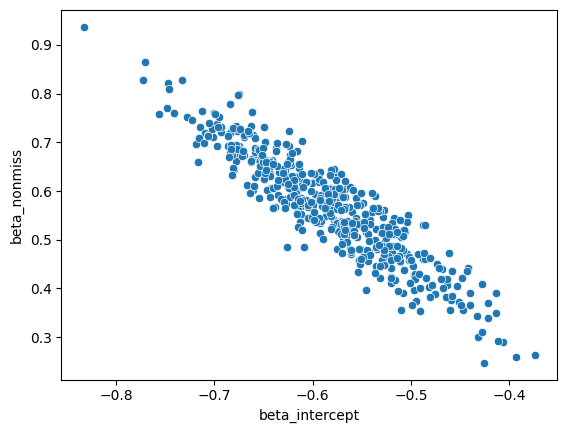

In [117]:
num_samples_posterior = 500   

params_posterior = []
for i in range(num_samples_posterior):
    param_sample_svi = guide.forward()
    params_posterior.append(
        {
            'beta_intercept': float(param_sample_svi['beta_intercept'].detach().numpy()),
            'beta_nonmiss': float(param_sample_svi['beta_nonmiss'].detach().numpy()),
        }
    )

params_posterior = pd.DataFrame(params_posterior)


sns.scatterplot(x='beta_intercept', y='beta_nonmiss', data=params_posterior)


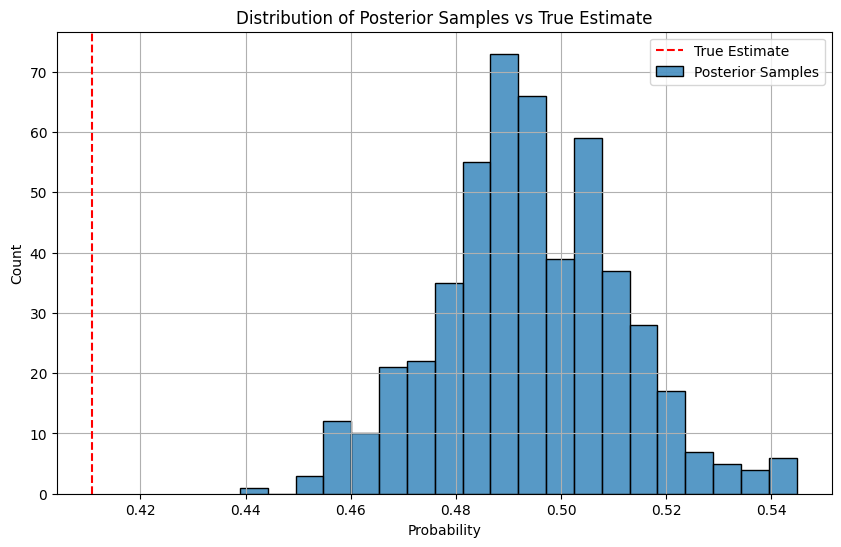

In [120]:
def predict_logodds_from_posterior(params, x):
    # Specify parameters
    num_points = x.shape[0]
    ## MAP parameters
    beta_price = params['beta_price']
    beta_gender = params['beta_gender']
    beta_income = params['beta_income']
    beta_exposure = params['beta_exposure']
    ## SVI parameters
    beta_intercept = params['beta_intercept']
    beta_nonmiss = params['beta_nonmiss']
    
    # Logistic Regression
    log_odds = torch.matmul(
        torch.cat([x, torch.ones(num_points, 1)], dim=1),
        torch.tensor([beta_price, beta_gender, beta_income, beta_exposure, beta_intercept])
    )
    return log_odds

num_samples_posterior = 500 
results_posterior = []

for i in range(num_samples_posterior):
    param_sample_svi = guide.forward()

    log_odds_posterior = predict_logodds_from_posterior(
        params={
            'beta_price': beta_price_map,
            'beta_gender': beta_gender_map,
            'beta_income': beta_income_map,
            'beta_exposure': beta_exposure_map,
            'beta_intercept': param_sample_svi['beta_intercept'],
            'beta_nonmiss': param_sample_svi['beta_nonmiss'],
        }, 
        x=x,
    )

    results_posterior.append(torch.sigmoid(log_odds_posterior).mean())

results_posterior = torch.tensor(results_posterior)


# Plot distribution of posterior results and compare to MAP estimate
plt.figure(figsize=(10, 6))
sns.histplot(results_posterior, bins=20, label='Posterior Samples')
true_estimate = torch.sigmoid(log_odds).mean()
plt.axvline(x=true_estimate, color='r', linestyle='--', label='True Estimate')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.title('Distribution of Posterior Samples vs True Estimate')
plt.legend()
plt.grid(True)

In [68]:
# import seaborn as sns
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=torch.sigmoid(log_odds).detach(), y=torch.sigmoid(log_odds_posterior).detach())
# plt.xlabel('Log Odds (MAP)')
# plt.ylabel('Log Odds (Posterior)')
# plt.title('Comparison of MAP vs Posterior Log Odds')
# plt.plot([-1, 1], [-1, 1], 'r--')  # Add diagonal reference line
# plt.grid(True)
